In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, average_precision_score, \
precision_recall_curve
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [2]:
master_df = pd.read_csv('core/master.csv')
awards_df = pd.read_csv('core/AwardsPlayers.csv')
batting_df = pd.read_csv('core/Batting.csv')
field_df = pd.read_csv('core/Fielding.csv')
allstar_df = pd.read_csv('core/AllStarFull.csv')

In [3]:
gg_df = awards_df[awards_df.awardID=='Gold Glove']

In [4]:
stats_df = pd.concat([batting_df, field_df])

In [5]:
stats_df = stats_df[stats_df['yearID']>1956]

In [6]:
stats_df.head()

,2B,3B,A,AB,BB,CS,DP,E,G,GIDP,...,SF,SH,SO,WP,ZR,lgID,playerID,stint,teamID,yearID
38725,27.0,6.0,NaN,615.0,57.0,1.0,NaN,NaN,151,13.0,...,3.0,0.0,58.0,NaN,NaN,NL,aaronha01,1,ML1,1957
38726,0.0,0.0,NaN,8.0,1.0,0.0,NaN,NaN,28,0.0,...,0.0,0.0,4.0,NaN,NaN,AL,aberal01,1,DET,1957
38727,0.0,0.0,NaN,1.0,0.0,0.0,NaN,NaN,3,0.0,...,0.0,0.0,0.0,NaN,NaN,AL,aberal01,2,KC1,1957
38728,1.0,0.0,NaN,24.0,1.0,0.0,NaN,NaN,26,2.0,...,0.0,2.0,5.0,NaN,NaN,AL,abernte02,1,WS1,1957
38729,0.0,0.0,NaN,19.0,3.0,0.0,NaN,NaN,49,0.0,...,0.0,2.0,15.0,NaN,NaN,NL,ackerto01,1,CIN,1957


In [7]:
gg_df.head()

,playerID,awardID,yearID,lgID,tie,notes
2105,hodgegi01,Gold Glove,1957,ML,NaN,1B
2106,foxne01,Gold Glove,1957,ML,NaN,2B
2107,malzofr01,Gold Glove,1957,ML,NaN,3B
2108,lollash01,Gold Glove,1957,ML,NaN,C
2109,mayswi01,Gold Glove,1957,ML,NaN,CF


In [8]:
allstar_df.head()

,playerID,yearID,gameNum,gameID,teamID,lgID,GP,startingPos
0,gomezle01,1933,0,ALS193307060,NYA,AL,1.0,1.0
1,ferreri01,1933,0,ALS193307060,BOS,AL,1.0,2.0
2,gehrilo01,1933,0,ALS193307060,NYA,AL,1.0,3.0
3,gehrich01,1933,0,ALS193307060,DET,AL,1.0,4.0
4,dykesji01,1933,0,ALS193307060,CHA,AL,1.0,5.0


In [9]:
# create a dictionary that gives the all start position corresponding year and player
combi_allstar = {}
for year, player, pos in zip(allstar_df['yearID'], allstar_df['playerID'], allstar_df['startingPos']):
    if pos == 7 or pos == 8 or pos == 9:
        combi_allstar[(year, player)] = 1
    else:    
        combi_allstar[(year, player)] = 0

In [10]:
def get_allstar(row):

    try:
        return combi_allstar[(row['yearID'], row['playerID'])]
    except KeyError:
        return 0

In [11]:
stats_df['allstar'] = stats_df.apply(get_allstar, axis = 1)

In [12]:
# create a dictionary that gives the position corresponding year and player
combi = {}
for year, player, notes in zip(gg_df['yearID'], gg_df['playerID'], gg_df['notes']):
    if notes == 'LF' or notes == 'RF' or notes == 'CF':
        combi[(year, player)] = 'OF'
    else:    
        combi[(year, player)] = notes

In [13]:
def get_position(row):

    try:
        return combi[(row['yearID'], row['playerID'])]
    except KeyError:
        return 'false'


In [14]:
stats_df['GG'] = stats_df.apply(get_position, axis = 1)

In [15]:
def get_previous(row):

    try:
        i = 1
        num = 0
        while combi.get((row['yearID']-i, row['playerID']), False):
            pos = combi[(row['yearID']-i, row['playerID'])]
            if pos == 'LF' or pos == 'RF' or pos == 'CF' or pos == 'OF':
                num += 1
                
            i += 1
            
        return num            
    
    except KeyError:
        return 0

In [16]:
stats_df['previous'] = stats_df.apply(get_previous, axis = 1)


In [17]:
stats_df.previous.value_counts()

0     146413
1        339
2        143
3         91
4         60
5         40
6         29
7         22
8         15
9         12
10        10
11         5
12         3
Name: previous, dtype: int64

In [18]:
stats_df.POS.value_counts()

P     29839
OF    16252
1B     8667
3B     8396
2B     7461
SS     6520
C      5956
Name: POS, dtype: int64

In [19]:
stats_wona_df = stats_df.apply(lambda x : x.fillna(x.mean()) if x.dtype.kind in 'biufc' else x.fillna('.'))

In [20]:
stats_wona_df.head()

,2B,3B,A,AB,BB,CS,DP,E,G,GIDP,...,WP,ZR,lgID,playerID,stint,teamID,yearID,allstar,GG,previous
38725,27.0,6.0,31.320937,615.0,57.0,1.0,7.386985,2.237487,151,13.0,...,12.015492,0.695152,NL,aaronha01,1,ML1,1957,1,false,0
38726,0.0,0.0,31.320937,8.0,1.0,0.0,7.386985,2.237487,28,0.0,...,12.015492,0.695152,AL,aberal01,1,DET,1957,0,false,0
38727,0.0,0.0,31.320937,1.0,0.0,0.0,7.386985,2.237487,3,0.0,...,12.015492,0.695152,AL,aberal01,2,KC1,1957,0,false,0
38728,1.0,0.0,31.320937,24.0,1.0,0.0,7.386985,2.237487,26,2.0,...,12.015492,0.695152,AL,abernte02,1,WS1,1957,0,false,0
38729,0.0,0.0,31.320937,19.0,3.0,0.0,7.386985,2.237487,49,0.0,...,12.015492,0.695152,NL,ackerto01,1,CIN,1957,0,false,0


In [21]:
stats_wona_df.columns.values

array(['2B', '3B', 'A', 'AB', 'BB', 'CS', 'DP', 'E', 'G', 'GIDP', 'GS',
       'H', 'HBP', 'HR', 'IBB', 'InnOuts', 'PB', 'PO', 'POS', 'R', 'RBI',
       'SB', 'SF', 'SH', 'SO', 'WP', 'ZR', 'lgID', 'playerID', 'stint',
       'teamID', 'yearID', 'allstar', 'GG', 'previous'], dtype=object)

In [22]:
#stats_pre_df.columns.values
stats_OF_df = stats_wona_df[stats_wona_df['POS']=='OF']
stats_OF_df.loc[stats_OF_df['GG']!='OF', 'GG'] = 0
stats_OF_df.loc[stats_OF_df['GG']=='OF', 'GG'] = 1

C:\Users\the_b\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [23]:
stats_pre_OF_df = stats_OF_df.drop(['lgID', 'playerID', 'teamID'], axis=1)
#stats_pre_OF_df = pd.get_dummies(stats_pre_OF_df, columns=['POS'])

In [24]:
X = stats_pre_OF_df.drop(['GG', 'POS'], axis=1)
y = list(stats_pre_OF_df['GG'].values)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


model = DecisionTreeClassifier()
model.fit(X_train, y_train)
predicted = model.predict(X_test)
print(confusion_matrix(y_test, predicted))
predicted_train = model.predict(X_train)
print(confusion_matrix(y_train, predicted_train))
target_names = (['0','1'])
print(classification_report(y_test,
                            predicted,
                            target_names=target_names))
print(accuracy_score(y_test, predicted))

[[3120   58]
 [  39   34]]
[[12712     0]
 [    0   289]]
             precision    recall  f1-score   support

          0       0.99      0.98      0.98      3178
          1       0.37      0.47      0.41        73

avg / total       0.97      0.97      0.97      3251

0.970163026761


In [49]:
rf_model = RandomForestClassifier(n_estimators=100)

rf_model.fit(X_train, y_train)
predicted = rf_model.predict(X_test)
print(confusion_matrix(y_test, predicted))
predicted_train = rf_model.predict(X_train)
print(confusion_matrix(y_train, predicted_train))
target_names = (['0','1'])
print(classification_report(y_test,
                            predicted,
                            target_names=target_names))
print(accuracy_score(y_test, predicted))

[[3163   15]
 [  38   35]]
[[12712     0]
 [    1   288]]
             precision    recall  f1-score   support

          0       0.99      1.00      0.99      3178
          1       0.70      0.48      0.57        73

avg / total       0.98      0.98      0.98      3251

0.9836973239


In [50]:
y_pred_probs = rf_model.predict_proba(X_test)
print('Some example probabilities:', y_pred_probs[:10])

# y_pred_probs contains probabilities for both '1' and '0'. we only
# care about the probabilities of '1', so we extract it below.
high_index = rf_model.classes_.tolist().index(1) # this '1' corresponds to what you want to return
y_high_probs = [y_pred_probs[i, high_index] for i in range(y_pred_probs.shape[0])]

print("Just the '1' probabilities:", y_high_probs[:10])

Some example probabilities: [[ 1.    0.  ]
 [ 1.    0.  ]
 [ 1.    0.  ]
 [ 1.    0.  ]
 [ 1.    0.  ]
 [ 1.    0.  ]
 [ 1.    0.  ]
 [ 1.    0.  ]
 [ 0.3   0.7 ]
 [ 0.97  0.03]]
Just the '1' probabilities: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.69999999999999996, 0.029999999999999999]


(array([ 0.02245463,  0.11024845,  0.13944223,  0.16509434,  0.1897019 ,
        0.20720721,  0.22483221,  0.23809524,  0.25490196,  0.27234043,
        0.28310502,  0.30541872,  0.31937173,  0.32608696,  0.3372093 ,
        0.34355828,  0.36601307,  0.39285714,  0.41085271,  0.41803279,
        0.42372881,  0.43243243,  0.44859813,  0.45098039,  0.46938776,
        0.4893617 ,  0.51111111,  0.51685393,  0.52873563,  0.53488372,
        0.52439024,  0.5375    ,  0.55263158,  0.56164384,  0.56944444,
        0.56338028,  0.57971014,  0.58208955,  0.58461538,  0.6031746 ,
        0.62295082,  0.6440678 ,  0.65517241,  0.66666667,  0.66071429,
        0.67272727,  0.69811321,  0.69230769,  0.70588235,  0.7       ,
        0.72916667,  0.74468085,  0.73913043,  0.75609756,  0.74358974,
        0.72972973,  0.77142857,  0.76470588,  0.75757576,  0.77419355,
        0.79310345,  0.80769231,  0.86956522,  0.86363636,  0.94444444,
        1.        ,  1.        ,  1.        ,  1.        ,  1. 

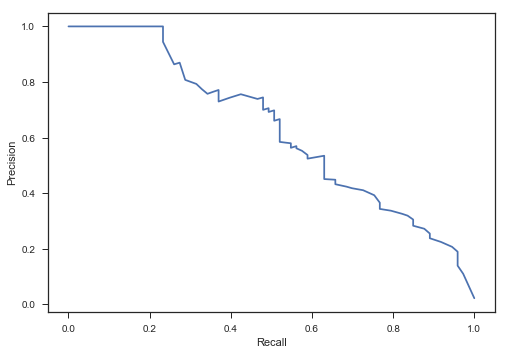

In [51]:
average_precision = average_precision_score (y_test, y_high_probs)
precisions, recalls, _ = precision_recall_curve(y_test, y_high_probs)
print(precision_recall_curve(y_test, y_high_probs))
print('Average precision is', average_precision)
plt.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [28]:
features_importances = list(zip(X.columns, model.feature_importances_))
features_importances.sort(key=lambda x:x[1], reverse=True)
features_importances[:10]

[('previous', 0.34606827186179823),
 ('PO', 0.14290198496049386),
 ('GS', 0.095152099118542319),
 ('yearID', 0.093528151166623386),
 ('InnOuts', 0.077128309028036357),
 ('A', 0.074529818807100537),
 ('E', 0.066397745718473747),
 ('G', 0.062830462871459714),
 ('DP', 0.030524963576951159),
 ('allstar', 0.010926219529521983)]

In [29]:
features_importances = list(zip(X.columns, rf_model.feature_importances_))
features_importances.sort(key=lambda x:x[1], reverse=True)
features_importances[:10]

[('previous', 0.22363844947166883),
 ('PO', 0.16234794601309971),
 ('InnOuts', 0.1209001462180693),
 ('GS', 0.10697642963810641),
 ('G', 0.084531870838176884),
 ('yearID', 0.076774629727582713),
 ('A', 0.074871822181843434),
 ('E', 0.066416371986335862),
 ('allstar', 0.042727349695258356),
 ('DP', 0.0400785636937794)]

boxplots  

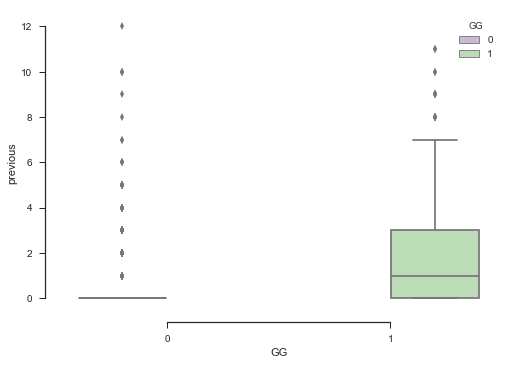

In [41]:
#stats_box = stats_pre_OF_df.loc(['previous', 'GG'])

sns.set(style="ticks")

# Draw a nested boxplot to show bills by day and sex
sns.boxplot(x="GG", y="previous", hue='GG', data=stats_pre_OF_df, palette="PRGn")
sns.despine(offset=10, trim=True)
sns.plt.show()

barplots  
features heatmap  
zone rating with year

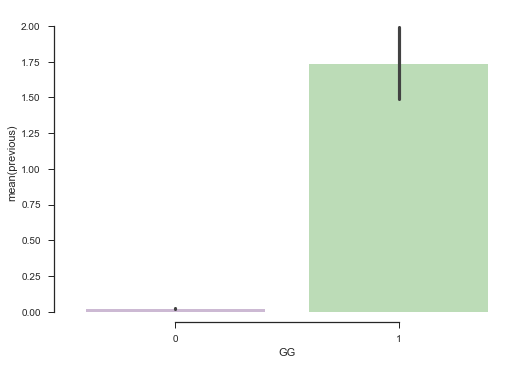

In [43]:
sns.barplot(x="GG", y="previous", data=stats_pre_OF_df, palette="PRGn")
sns.despine(offset=10, trim=True)
sns.plt.show()

random forest: class_weight
how to capture(visualize) features which distinguish between winner and loser
clustering algorithm
salary